In [1]:
%matplotlib notebook

In [2]:
SMPLSH_Dir = r'..\SMPL_Socks\SMPL_reimp'

import sys
sys.path.insert(0, SMPLSH_Dir)
import smplsh_torch
import numpy as np

import os
import torch
import matplotlib.pyplot as plt
from skimage.io import imread

# Util function for loading meshes
from pytorch3d.io import load_objs_as_meshes
from tqdm import tqdm_notebook
import torch.nn as nn
import torch.nn.functional as F
# Data structures and functions for rendering
from pytorch3d.structures import Meshes, Textures
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    TexturedSoftPhongShader,
    SoftSilhouetteShader,
    SoftPhongShader,
    HardPhongShader,
    BlendParams
)
from pytorch3d.transforms.so3 import (
    so3_exponential_map,
    so3_relative_angle,
)
# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))
import json
from os.path import join

In [3]:
outFolder = r'F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest'

In [4]:
smplshData = r'C:\Code\MyRepo\ChbCapture\06_Deformation\SMPL_Socks\SMPLSH\SmplshModel.npz'
# Setup
device = torch.device("cuda:0")
torch.cuda.set_device(device)

pose_size = 3 * 52
beta_size = 10

smplsh = smplsh_torch.SMPLModel(device, smplshData)
np.random.seed(9608)
pose = torch.from_numpy((np.random.rand(pose_size) - 0.5) * 0.4)\
        .type(torch.float64).to(device)
betas = torch.from_numpy((np.random.rand(beta_size) - 0.5) * 0.06) \
        .type(torch.float64).to(device)
trans = torch.from_numpy(np.zeros(3)).type(torch.float64).to(device)

verts = smplsh(betas, pose, trans).type(torch.float32)
# Initialize each vertex to be gray in color.
verts_rgb = ( 0.5 *torch.ones_like(verts))[None]  # (1, V, 3)
textures = Textures(verts_rgb=verts_rgb.to(device))

smplshMesh = Meshes([verts], [smplsh.faces.to(device)], textures=textures)


In [7]:
class RenderingCfg:
    def __init__(s):
        s.sigma = 1e-4
        s.blurRange = 1e-4
        s.faces_per_pixel = 50
        s.bodyJointOnly = False
        s.randSeedPerturb = 1234
        s.noiseLevel = 0.5
        s.numIterations = 2000
        s.learningRate = 0.01
        s.terminateLoss = 200
        s.plotStep = 20
        
cfg = RenderingCfg()

cfg.noiseLevel = 0.2

# cfg.faces_per_pixel = 20
# cfg.blurRange = 0
# cfg.blurRange = 1e-3
# cfg.sigma = 1e-5

In [8]:
# Initialize an OpenGL perspective camera.
# With world coordinates +Y up, +X left and +Z in, the front of the cow is facing the -Z direction. 
# So we move the camera by 180 in the azimuth direction so it is facing the front of the cow. 
R, T = look_at_view_transform(2.7, 0, 180) 
cameras = OpenGLPerspectiveCameras(device=device, R=R, T=T)
# blend_params = BlendParams(sigma=1e-4, gamma=1e-4)
blend_params = BlendParams(sigma=cfg.sigma, gamma=1e-4)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. Refer to rasterize_meshes.py for explanations of these parameters. 
if cfg.blurRange!= 0:
    raster_settings = RasterizationSettings(
        image_size=512, 
    #     blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        blur_radius= np.log(1. / cfg.blurRange - 1.) * blend_params.sigma, 
    #     blur_radius= 0, 
        # blur_radius=0.0005, 
    #     faces_per_pixel=10, 

      faces_per_pixel=cfg.faces_per_pixel, 

        bin_size=0
    )
else:
    raster_settings = RasterizationSettings(
        image_size=512, 
    #     blur_radius= np.log(1. / 1e-4 - 1.) * blend_params.sigma, 
        blur_radius= 0, 
    #     blur_radius= 0, 
        # blur_radius=0.0005, 
    #     faces_per_pixel=10, 

      faces_per_pixel=cfg.faces_per_pixel, 

        bin_size=0
    )

# Place a point light in front of the object. As mentioned above, the front of the cow is facing the 
# -z direction. 
lights = PointLights(device=device, location=[[0.0, 0.0, -3.0]])

# Create a phong renderer by composing a rasterizer and a shader. The textured phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )
renderer = MeshRenderer(
    rasterizer = rasterizer,
#     shader=SoftPhongShader(
#         device=device, 
#         cameras=cameras,
#         lights=lights,
#         blend_params=blend_params
#     )
    shader=SoftSilhouetteShader(
        blend_params=blend_params
        # device=device, 
        # cameras=cameras,
        # lights=lights
    )
)

<IPython.core.display.Javascript object>


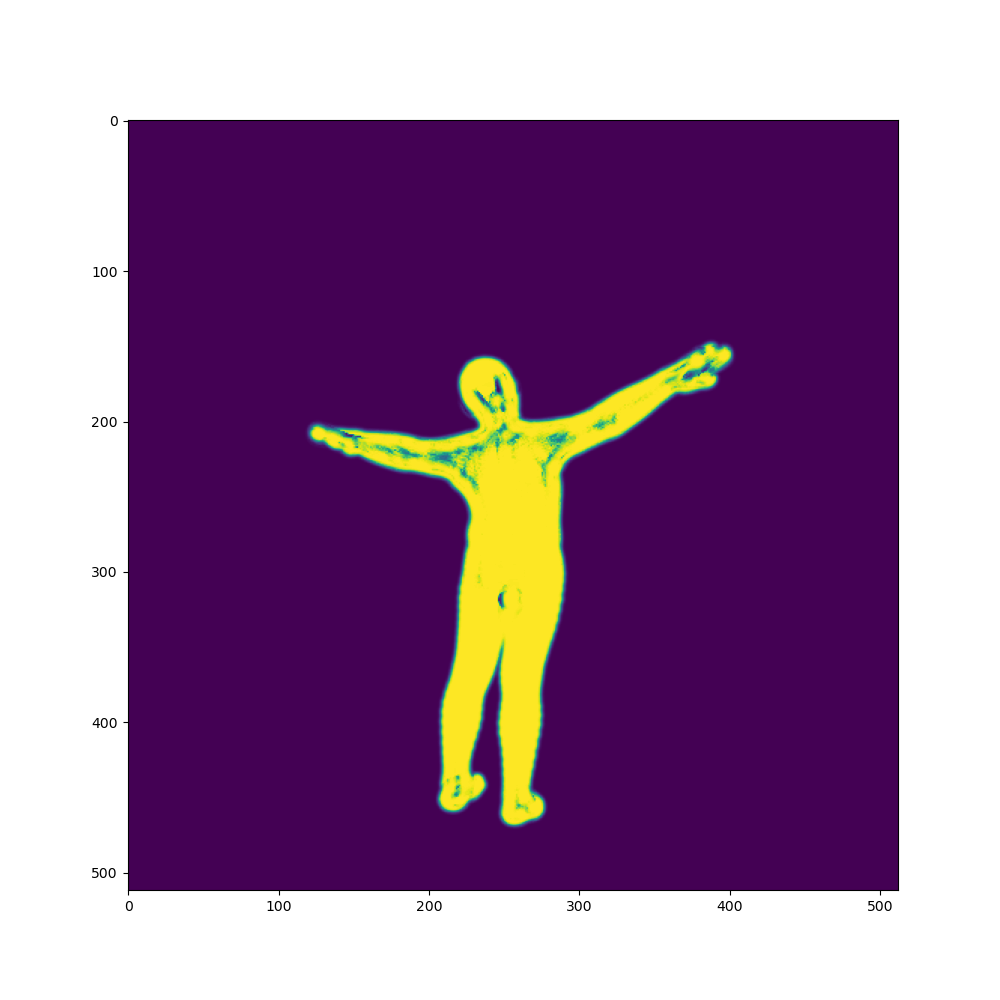

In [9]:
with torch.no_grad():
    imageRef = renderer(smplshMesh)
plt.figure(figsize=(10, 10))
plt.imshow(imageRef[0, ..., 3].cpu().numpy())

In [10]:
np.random.seed(cfg.randSeedPerturb)

if cfg.bodyJointOnly:
    numParameters = 3 * 22
else:
    numParameters = 3 * 52
# posePerturbed = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
# Keep hand fixed
if cfg.bodyJointOnly:
    poseHands = pose[numBodyParameters:].clone().detach()
    poseParams = torch.tensor(pose[:numBodyParameters].cpu().numpy() + (np.random.rand(numBodyParameters) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = torch.cat([poseParams, poseHands])
else:
    poseParams  = torch.tensor(pose.cpu().numpy() + (np.random.rand(pose_size) - 0.5) * cfg.noiseLevel, dtype=torch.float64, device=device, requires_grad=True)
    posePerturbed = poseParams

In [11]:
posePerturbed

tensor([-0.0966, -0.1585,  0.0254,  0.1499, -0.0251,  0.0930,  0.0400,  0.1571,
         0.1838,  0.0596,  0.0061,  0.0357,  0.0442, -0.0981, -0.1241,  0.1468,
        -0.1649, -0.2127, -0.0344,  0.0332, -0.1428,  0.0513, -0.0137, -0.1987,
         0.0551,  0.0711, -0.0058,  0.0832, -0.1878, -0.1289, -0.0469,  0.1317,
        -0.1321, -0.1855, -0.1052,  0.2223, -0.1904,  0.0683, -0.1286,  0.1143,
        -0.0975,  0.0535,  0.0788, -0.1056,  0.0935,  0.1430,  0.0539, -0.0170,
         0.0582, -0.0255,  0.0169, -0.0459, -0.0173, -0.2904,  0.1177, -0.0253,
         0.2196,  0.1411,  0.1345, -0.1403,  0.0118,  0.1811, -0.0055,  0.1207,
        -0.2022, -0.0422,  0.1886, -0.0942,  0.1098,  0.0486,  0.0416, -0.0994,
        -0.0140, -0.0652,  0.0155,  0.1724,  0.0592, -0.1052,  0.0355, -0.0850,
         0.0213, -0.0116,  0.1053,  0.1973, -0.0092, -0.0488,  0.1341,  0.1262,
         0.0607, -0.0306,  0.0027, -0.0256, -0.1462,  0.0493, -0.0142,  0.1552,
         0.1675,  0.1389, -0.1478,  0.13

<IPython.core.display.Javascript object>


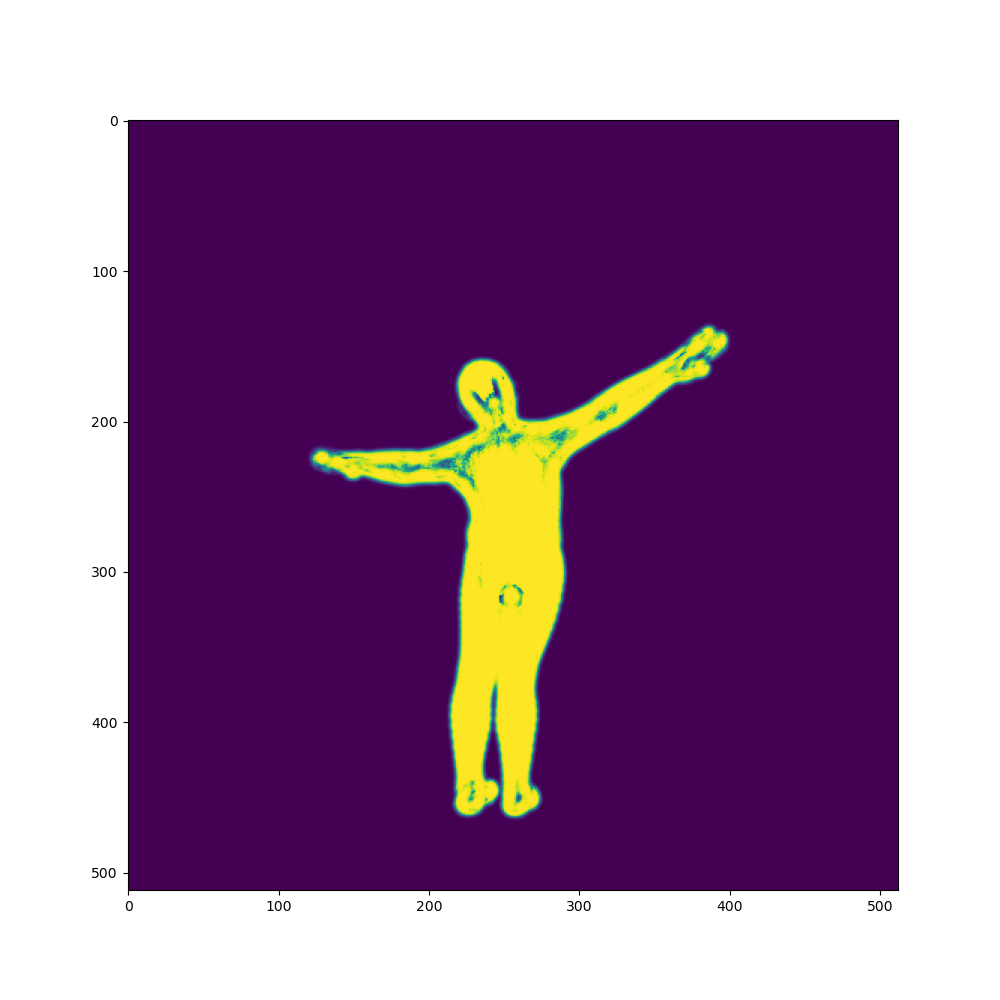

In [12]:
vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
with torch.no_grad():
    image = renderer(smplshMeshPerturbed)
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., 3].cpu().detach().numpy())

In [13]:
memStats = torch.cuda.memory_stats(device=device)
print('Before release: active_bytes.all.current:',memStats['active_bytes.all.current'] / 1000000)
torch.cuda.empty_cache()
memStats = torch.cuda.memory_stats(device=device)
print('After release: active_bytes.all.current:',memStats['active_bytes.all.current'] / 1000000)
optimizer = torch.optim.Adam([poseParams], lr=cfg.learningRate)

Before release: active_bytes.all.current: 94.156288
After release: active_bytes.all.current: 94.156288


In [14]:
loss = torch.sum((imageRef[..., 3] - image[..., 3]) ** 2)
print(loss.item())

4521.7861328125


In [15]:
expName = 'Param_Sig' + str(cfg.sigma) + '_BRange' + str(cfg.blurRange) + '_Fpp' + str(cfg.faces_per_pixel) + '_BodyOnly' + str(cfg.bodyJointOnly)
outFolderForExperiment = join(outFolder, expName)
os.makedirs(outFolderForExperiment, exist_ok=True)
print(outFolderForExperiment)

json.dump(cfg.__dict__, open(join(outFolderForExperiment, 'cfg.json'), 'w'), indent=2)

F:\WorkingCopy2\2020_04_20_DifferentiableRendererTest\Param_Sig0.0001_BRange0.0001_Fpp50_BodyOnlyFalse


In [16]:
poses = []
losses = []

In [34]:
loop = tqdm_notebook(range(cfg.numIterations))
for i in loop:
    optimizer.zero_grad()
    torch.cuda.empty_cache()

    if cfg.bodyJointOnly:
        poseHands = pose[numBodyParameters:].clone().detach()
        posePerturbed = torch.cat([poseParams, poseHands])
    else:
        posePerturbed = poseParams
    
    vertsPerturbed = smplsh(betas, posePerturbed, trans).type(torch.float32)
    smplshMeshPerturbed = Meshes([vertsPerturbed], [smplsh.faces.to(device)], textures=textures)
    
    images = renderer(smplshMeshPerturbed)
    # targetImg = images[0, ..., :3]
    loss = torch.sum((imageRef[..., 3] - images[..., 3]) ** 2)
    # loss, _ = model()
    
    # recordData
    losses.append(loss.item())
    poses.append(posePerturbed.cpu().detach().numpy())
    
#     for cam in cameras:
#         image = render(...)
    loss.backward()
        
    optimizer.step()
    
    loop.set_description('Optimizing (loss %.4f, poseDiff: %.4f)' % (loss.data, torch.sum((pose-posePerturbed)**2).item()))
    
    if loss.item() < cfg.terminateLoss:
        break
    
    # Save outputs to create a GIF. 
    if i % cfg.plotStep == 0:
        # R = look_at_rotation(model.camera_position[None, :], device=model.device)
        # T = -torch.bmm(R.transpose(1, 2), model.camera_position[None, :, None])[:, :, 0]   # (1, 3)
        # image = phong_renderer(meshes_world=model.meshes.clone(), R=R, T=T)
        # image = image[0, ..., :3].detach().squeeze().cpu().numpy()
        # image = img_as_ubyte(image)
        # writer.append_data(image)
        
        plt.figure()
        plt.imshow(images[0, ..., 3].cpu().detach().numpy())
        plt.title("iter: %d, loss: %0.2f" % (i, loss.data))
        outImgFile = join(outFolderForExperiment, 'Fig_' + str(i).zfill(5) + '.png')
        plt.savefig(outImgFile)
        plt.grid("off")
        plt.axis("off")
        
np.save(join(outFolderForExperiment, 'Losses.npy'), np.array(losses))
np.save(join(outFolderForExperiment, 'Poses.npy'), np.array(poses))
np.save(join(outFolderForExperiment, 'PoseTarget.npy'), pose.cpu().numpy())

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: 

In [35]:
np.save(join(outFolderForExperiment, 'Losses.npy'), np.array(losses))
np.save(join(outFolderForExperiment, 'Poses.npy'), np.array(poses))
np.save(join(outFolderForExperiment, 'PoseTarget.npy'), pose.cpu().numpy())

In [41]:
losses

[9506.2568359375,
 7406.6513671875,
 6886.2275390625,
 6958.22607421875,
 6388.01953125,
 5450.345703125,
 4336.8447265625,
 3530.34033203125,
 3041.119140625,
 2487.675537109375,
 2620.35546875,
 3018.94921875,
 3152.697265625,
 2992.289794921875,
 2817.600341796875,
 2664.62060546875,
 2377.040283203125,
 2097.706787109375,
 2067.110595703125,
 2049.884765625,
 1888.946044921875,
 1695.7462158203125,
 1597.549560546875,
 1503.070068359375,
 1426.1810302734375,
 1446.0723876953125,
 1435.5572509765625,
 1333.0792236328125,
 1200.65966796875,
 1093.01123046875,
 974.8344116210938,
 871.283935546875,
 818.3933715820312,
 768.3463134765625,
 730.6134643554688,
 752.288330078125,
 761.093017578125,
 709.0321044921875,
 631.6992797851562,
 565.8790283203125,
 538.5908813476562,
 526.2700805664062,
 500.3792724609375,
 458.8973693847656,
 417.11181640625,
 392.2567138671875,
 403.2952880859375,
 383.05902099609375,
 348.8811950683594,
 327.6263427734375,
 331.4458923339844,
 337.82775878906

C:\Users\Anka\.conda\envs\pytorch3d\lib\site-packages\ipykernel_launcher.py:1: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>


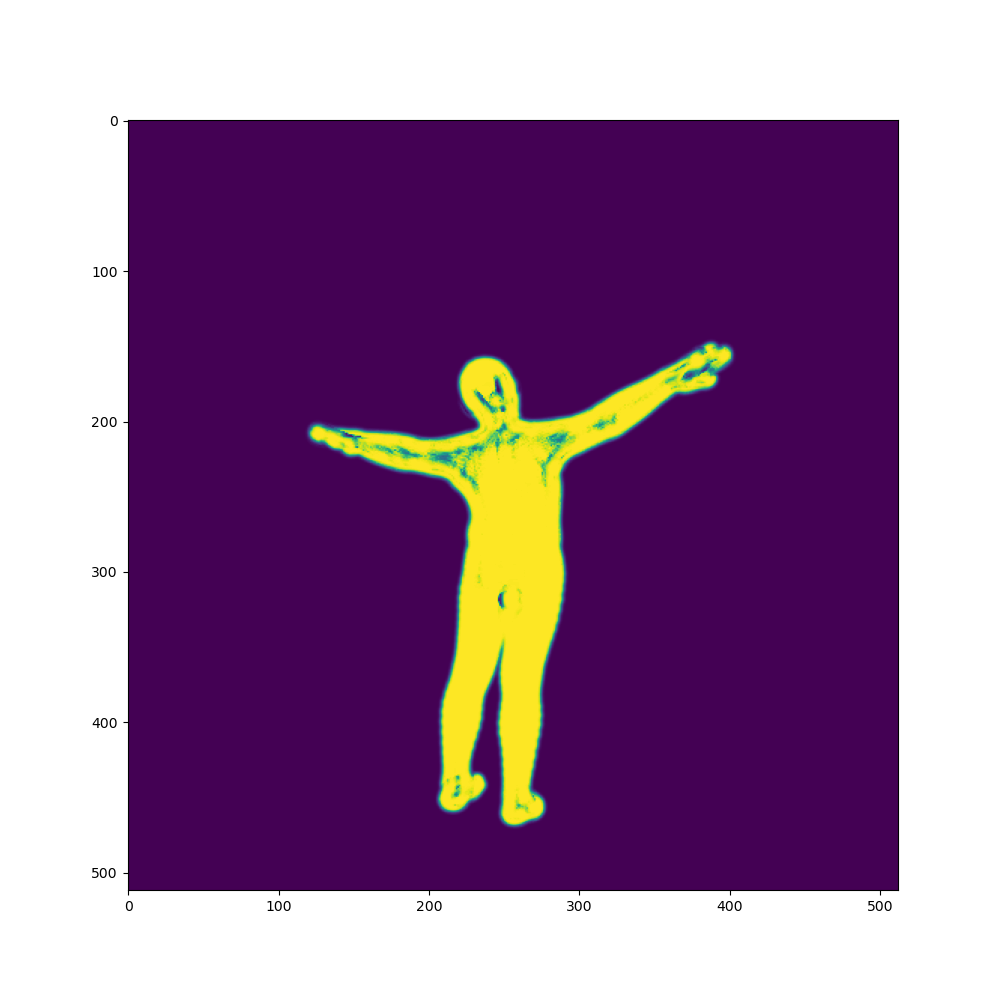

In [41]:
plt.figure(figsize=(10, 10))
plt.imshow(imageRef[0, ..., 3].cpu().detach().numpy())
outImgFile = join(outFolderForExperiment, 'Target' + '.png')
plt.savefig(outImgFile)